<a href="https://colab.research.google.com/github/lavanyasatpute/lavanyasatpute/blob/main/New_Cusmize_Detectron2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  2.5 ; cuda:  cu121


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3nwqe_tp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3nwqe_tp
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

In [ ]:
import torch.nn as nn
from detectron2.modeling import BACKBONE_REGISTRY, Backbone
from detectron2.layers import ShapeSpec

In [ ]:
import logging
import math
import fvcore.nn.weight_init as weight_init
import torch
import torch.nn as nn

from detectron2.layers import CNNBlockBase, Conv2d, get_norm
from detectron2.modeling.backbone.fpn import _assert_strides_are_log2_contiguous

from detectron2.modeling.backbone import Backbone
from detectron2.modeling.backbone.utils import PatchEmbed, window_partition, window_unpartition

logger = logging.getLogger(__name__)

__all__ = ["PyramidViT", "SimpleFeaturePyramid", "get_pvt_lr_decay_rate"]

class SRAttention(nn.Module):
    """Spatial Reduction Attention block."""

    def __init__(
        self,
        dim,
        num_heads=8,
        sr_ratio=1,
        qkv_bias=True,
    ):
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            sr_ratio (int): Spatial reduction ratio.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, H, W, C = x.shape
        q = self.q(x).reshape(B, H * W, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 3, 1, 2)
            x_ = self.sr(x_).permute(0, 2, 3, 1).reshape(B, -1, C)
            x_ = self.norm(x_)
        else:
            x_ = x.reshape(B, H * W, C)

        kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, H, W, C)
        x = self.proj(x)

        return x

class PyramidBlock(nn.Module):
    """Transformer blocks with spatial reduction attention and MLP."""

    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=True,
        sr_ratio=1,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        act_layer=nn.GELU,
    ):
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each block.
            mlp_ratio (float): Ratio of MLP hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            sr_ratio (int): Spatial reduction ratio for attention.
            drop_path (float): Stochastic depth rate.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = SRAttention(dim, num_heads, sr_ratio=sr_ratio, qkv_bias=qkv_bias)

        from timm.models.layers import DropPath, Mlp

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PyramidViT(Backbone):
    """
    This module implements the Pyramid Vision Transformer (PVT) backbone.
    """

    def __init__(
        self,
        img_size=1024,
        patch_size=4,
        in_chans=3,
        embed_dims=(64, 128, 320, 512),
        num_heads=(1, 2, 5, 8),
        mlp_ratios=(8, 8, 4, 4),
        depths=(3, 4, 6, 3),
        sr_ratios=(8, 4, 2, 1),
        qkv_bias=True,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        act_layer=nn.GELU,
        use_abs_pos=True,
        out_features=["p2", "p3", "p4", "p5"],
    ):
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size for overlapping embedding.
            in_chans (int): Number of input image channels.
            embed_dims (tuple[int]): Embedding dimensions for each stage.
            num_heads (tuple[int]): Number of attention heads for each stage.
            mlp_ratios (tuple[float]): MLP ratio for each stage.
            depths (tuple[int]): Depth of each PVT stage.
            sr_ratios (tuple[int]): Spatial reduction ratios for each stage.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            drop_path_rate (float): Stochastic depth rate.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_abs_pos (bool): If True, use absolute positional embeddings.
            out_features (list[str]): List of feature names to output from the backbone.
        """
        super().__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dims[0], kernel_size=patch_size, stride=patch_size)

        self.blocks = nn.ModuleList()
        for i in range(len(embed_dims)):
            stage = nn.ModuleList([PyramidBlock(embed_dims[i], num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias, sr_ratio=sr_ratios[i], drop_path=drop_path_rate) for _ in range(depths[i])])
            self.blocks.append(stage)

        self.norms = nn.ModuleList([norm_layer(embed_dim) for embed_dim in embed_dims])

        self._out_features = out_features
        self._out_feature_channels = {f"p{i + 2}": embed_dims[i] for i in range(len(embed_dims))}
        self._out_feature_strides = {f"p{i + 2}": 2 ** (i + 2) for i in range(len(embed_dims))}

    def forward(self, x):
        outs = {}
        x = self.patch_embed(x)

        for i, block in enumerate(self.blocks):
            for blk in block:
                x = blk(x)
            x = self.norms[i](x)
            outs[f"p{i + 2}"] = x

        return outs


In [ ]:
# from detectron2.layers import ShapeSpec
# from detectron2.modeling import Backbone
# from detectron2.modeling.backbone import BACKBONE_REGISTRY

# class PyramidVisionTransformerBackbone(Backbone):
#     def __init__(self, cfg, input_shape: ShapeSpec):
#         super().__init__()

#         # Read config for number of classes and other parameters
#         self.num_classes = cfg.MODEL.PVIT.NUM_CLASSES
#         self.in_channels = input_shape.channels  # Input image channels
#         self.embed_dims = cfg.MODEL.PVIT.EMBED_DIMS  # Embedding dimensions
#         self.depths = cfg.MODEL.PVIT.DEPTHS  # Depth of each PViT stage
#         self.num_heads = cfg.MODEL.PVIT.NUM_HEADS  # Number of attention heads in each stage

#         # Initialize PViT architecture
#         self.pvit = PyramidVisionTransformer(
#             img_size=cfg.INPUT.IMAGE_SIZE,
#             in_channels=self.in_channels,
#             embed_dims=self.embed_dims,
#             depths=self.depths,
#             num_heads=self.num_heads,
#             num_classes=self.num_classes,
#         )

#         # Store output feature stride and channels for Detectron2
#         self._out_feature_strides = {"stage4": 32}  # Example: final stride of 32
#         self._out_feature_channels = {"stage4": self.embed_dims[-1]}  # Final stage output channels

#     def forward(self, x):
#         outputs = self.pvit(x)
#         return {"stage4": outputs}  # Return the output of the final stage

#     def output_shape(self):
#         return {
#             "stage4": ShapeSpec(
#                 channels=self._out_feature_channels["stage4"],
#                 stride=self._out_feature_strides["stage4"],
#             )
#         }


# # Register the PViT backbone with Detectron2
# @BACKBONE_REGISTRY.register()
# def build_pvit_backbone(cfg, input_shape):
#     return PyramidVisionTransformerBackbone(cfg, input_shape)


In [ ]:
from detectron2.modeling import BACKBONE_REGISTRY, FPN

@BACKBONE_REGISTRY.register()
def PVit_Lavanya2(cfg, input_shape):
    bottom_up = PyramidViT(
        img_size=cfg.INPUT.IMAGE_SIZE,
        patch_size=4,
        in_chans=3,
        embed_dims=(64, 128, 320, 512),  # Keep these as is
        num_heads=(1, 2, 5, 8),
        mlp_ratios=(8, 8, 4, 4),
        depths=(3, 4, 6, 3),
        sr_ratios=(8, 4, 2, 1),
        qkv_bias=True,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        act_layer=nn.GELU,
        use_abs_pos=True,
        out_features=["p2", "p3", "p4", "p5"],
    )

    # Wrap in FPN
    backbone = FPN(
        bottom_up=bottom_up,
        in_features=["p2", "p3", "p4", "p5"],
        out_channels=256,  # Output channels of FPN layers must be consistent
        # fpn_norm="BN"  # Optionally add batch normalization
    )
    return backbone


In [ ]:
from detectron2.modeling import BACKBONE_REGISTRY

@BACKBONE_REGISTRY.register()
def PViT_Lavanya3(cfg):
    # Initialize and return your PyramidViT instance here
    return PyramidViT(
        img_size=cfg.MODEL.BACKBONE.IMG_SIZE,
        patch_size=cfg.MODEL.BACKBONE.PATCH_SIZE,
        in_chans=cfg.MODEL.BACKBONE.IN_CHANS,
        embed_dims=cfg.MODEL.BACKBONE.EMBED_DIMS,
        num_heads=cfg.MODEL.BACKBONE.NUM_HEADS,
        mlp_ratios=cfg.MODEL.BACKBONE.MLP_RATIOS,
        depths=cfg.MODEL.BACKBONE.DEPTHS,
        sr_ratios=cfg.MODEL.BACKBONE.SR_RATIOS,
        qkv_bias=cfg.MODEL.BACKBONE.QKV_BIAS,
        drop_path_rate=cfg.MODEL.BACKBONE.DROP_PATH_RATE,
        norm_layer=cfg.MODEL.BACKBONE.NORM_LAYER,
        act_layer=cfg.MODEL.BACKBONE.ACT_LAYER,
        out_features=cfg.MODEL.BACKBONE.OUT_FEATURES,
    )


In [ ]:
# import torch
# from detectron2.layers import ShapeSpec

# # Assuming the PVTBackbone class is defined as shown before

# # Create a dummy input shape
# input_shape = ShapeSpec(channels=3)

# # Call the registered function to create the backbone instance
# backbone = PyramidViT(None)  # Pass the dummy input shape
# # Now backbone is an instance of the PVTBackbone class


# # Print the output shape of the backbone
# output_shapes = backbone.output_shape()

# # Iterate and print each feature map's output shape
# for name, shape_spec in output_shapes.items():
#     print(f"Feature: {name}, Channels: {shape_spec.channels}, Stride: {shape_spec.stride}")

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor , DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_dataset", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("Test_dataset", {}, "/content/test/_annotations.coco.json", "/content/test")

WARNING [10/24 05:02:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 05:02:17 d2.data.datasets.coco]: Loaded 7344 images in COCO format from /content/train/_annotations.coco.json


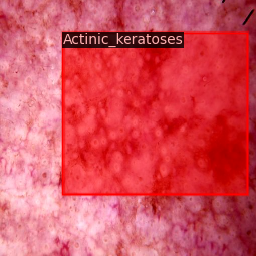

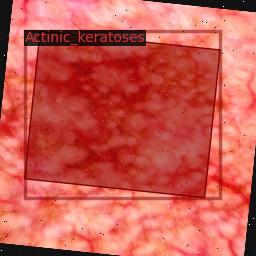

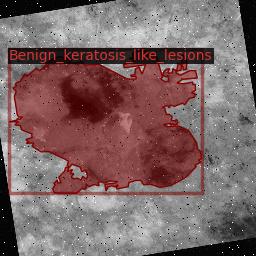

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("train_dataset")
dataset_dicts = DatasetCatalog.get("train_dataset")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()
# cfg.MODEL.BACKBONE.NAME = "build_pvit_backbone"
# cfg.MODEL.PVIT.EMBED_DIMS = [64, 128, 320, 512]
# cfg.MODEL.PVIT.DEPTHS = [2, 2, 6, 3]
# cfg.MODEL.PVIT.NUM_HEADS = [1, 2, 5, 8]
# cfg.MODEL.PVIT.NUM_CLASSES = 80
# cfg.INPUT.IMAGE_SIZE = 224
cfg.MODEL.BACKBONE.NAME = "PVit_Lavanya2"
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("Test_dataset")
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 350   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9

In [ ]:
# cfg.MODEL.BACKBONE.FREEZE_AT = 0

In [ ]:
# in_features = ["res1", "res2", "res3", "res4"]
# # Modify the config to use these features for the RPN
# cfg.MODEL.RPN.IN_FEATURES = in_features

In [ ]:
cfg.MODEL.ANCHOR_GENERATOR.IN_FEATURES = ["p2", "p3", "p4", "p5"]

In [ ]:
# cfg.merge_from_file(model_zoo.get_config_file("new_baselines/detr_r50.yaml"))


In [ ]:
# cfg.MODEL.RPN.ENABLED = False

In [ ]:
cfg.MODEL.RPN.IN_FEATURES = ["p2", "p3", "p4", "p5"]

In [ ]:
cfg.INPUT.IMAGE_SIZE = (512, 512)  # Set this to your desired input size (height, width)

In [ ]:
from detectron2.modeling import FPN
print(FPN.__init__.__code__)


<code object __init__ at 0x7a2457d2e4a0, file "/usr/local/lib/python3.10/dist-packages/detectron2/modeling/backbone/fpn.py", line 25>


In [ ]:
cfg = get_cfg()  # Get your Detectron2 configuration
cfg.MODEL.BACKBONE.NAME = "PViT_Lavanya3"  # Ensure this matches your custom backbone

# Update anchor generator and ROI heads to match your feature output
cfg.MODEL.ANCHOR_GENERATOR.IN_FEATURES = ["p2", "p3", "p4", "p5"]
cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p2", "p3", "p4", "p5"]

# Update output channel configuration based on your backbone
cfg.MODEL.BACKBONE.OUT_FEATURES = ["p2", "p3", "p4", "p5"]

# Set strides based on your implementation
# cfg.MODEL.BACKBONE.OUT_FEATURE_STRIDES = {f"p{i + 2}": 2 ** (i + 2) for i in range(len(embed_dims))}


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

TypeError: PViT_Lavanya3() takes 1 positional argument but 2 were given

In [ ]:
# # from detectron2.config import get_cfg
# # from detectron2.modeling import build_model
# # from detectron2.modeling.backbone import build_backbone
# # from detectron2.modeling.backbone.fpn import FPN, LastLevelMaxPool
# # from detectron2.engine import DefaultTrainer
# # from detectron2 import model_zoo
# # import torch

# # Get the configuration
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# # Set the custom PVT backbone
# cfg.MODEL.BACKBONE.NAME = "PVTBackbone"  # Ensure this matches the registered name of your PVT backbone

# # List of features from the custom backbone that will be used in FPN
# in_features = ["res2", "res3", "res4", "res5"]
# out_channels = 256  # Choose the desired output channel size for the FPN

# # Function to build the backbone with FPN
# def build_backbone_with_fpn(cfg, input_shape):
#     # Build the custom backbone
#     bottom_up = build_backbone(cfg, input_shape)
#     fpn = FPN(
#         bottom_up=bottom_up,
#         in_features=in_features,
#         out_channels=out_channels,
#         norm=cfg.MODEL.FPN.NORM,
#         top_block=LastLevelMaxPool(),
#         fuse_type=cfg.MODEL.FPN.FUSE_TYPE,
#     )
#     return fpn

# # Register the custom backbone builder
# from detectron2.modeling.backbone import BACKBONE_REGISTRY

# @BACKBONE_REGISTRY.register()
# def build_pvt_backbone_with_fpn(cfg, input_shape):
#     return build_backbone_with_fpn(cfg, input_shape)

# # Set the custom builder function for the model
# cfg.MODEL.BACKBONE.BUILDER = "build_pvt_backbone_with_fpn"

# # Set the FPN features for RPN and ROI heads
# cfg.MODEL.RPN.IN_FEATURES = ["p2", "p3", "p4", "p5"]  # FPN output names
# cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p2", "p3", "p4", "p5"]  # FPN output names

# # Adjust anchor sizes if needed (FPN usually uses different sizes)
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32], [64], [128], [256], [512]]

# # Build and print the model to verify
# model = build_model(cfg)
# print(model.backbone)

# # Train the model
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# Use the custom PVT backbone
cfg.MODEL.BACKBONE.NAME = "PVT_Backbone"

# Update in_features to match your backbone's output feature map names
cfg.MODEL.RPN.IN_FEATURES = ["res2", "res3", "res4", "res5"]  # Replace with your actual feature map names
cfg.MODEL.ROI_HEADS.IN_FEATURES = ["res2", "res3", "res4", "res5"]  # Replace with your actual feature map names

# Adjust anchor sizes to match the number of input features (4 in this case)
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]] # this should be a list of lists (e.g [[32, 64, 128, 256, 512]] )



In [ ]:
# Print the backbone's output shape to check the channel dimensions
from detectron2.modeling import build_model
model = build_model(cfg)
print(model.backbone.output_shape()) # Inspect the output shape of the backbone

In [ ]:
# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()